# Implementation of the SPT Model - Testing

Modifications: Johnny Esteves\ Author: Allen Pinjic - Created on June 21st, 2022

In [1]:
from astropy.io.fits import getdata
from astropy.table import Table
from astropy.cosmology import WMAP9 as cosmo
from colossus.cosmology import cosmology
from colossus.lss import mass_function
from __future__ import print_function, division
cosmology.setCosmology('WMAP9')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as plt
import pymc3 as pm
import aesara
import matplotlib.font_manager
import scipy.stats
import scipy.optimize
import seaborn as sns
import math
import os
import sys
import emcee
import pandas as pd
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
%matplotlib inline

## Creating a Simple Model via Simulated Data

In [4]:
sigma_chisi, sigma_lbd = 0.16, 0.169
rho = 0.79
Nclusters = 100000

# Cluster is defined as Mass (M) and redshift (z)

In [5]:
mfakes = 10**(np.random.uniform(14,15.2, size=Nclusters))
zfakes = np.random.uniform(0.1, 1.3, size=Nclusters)
# No "10^" for zfakes?
# Creating Nclusters number of fake mass 
# and redshift samples that are uniformly distributed

In [6]:
def _halo_mass_function(M, z):
    return mass_function.massFunction(M, z, mdef = '500c', model = 'bocquet16')
halo_mass_function = np.vectorize(_halo_mass_function)

def E(z):
    # The Hubble constant at the value of z
    Hz = cosmo.H(z).value
    # The Hubble constant at z=0
    H0 = cosmo.H(0).value
    return (Hz/H0)

p_halos = halo_mass_function(mfakes, zfakes)

indices_halos = np.random.choice(Nclusters, size = 1000, p = (p_halos/(np.sum(p_halos))))
# size = Nclusters/100 or 100,000/100 = 1000

In [7]:
# The creation of the fake samples for redshift and mass
# by chnaging the distribution from uniform to parabolic
zsims = zfakes[indices_halos]
msims = mfakes[indices_halos]

In [8]:
M0 = 3e14
Ez0 = E(0)

theta = [5.24, 1.534, 0.465, 0.161, 76.9, 1.02, 0.29, 0.16, 0.8]

A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
A_sze, B_sze, C_sze, scatter_sze = theta[:4]
rho = theta[-1]

def ln_zeta_given_M(theta_sze,M,z):
    return (np.log(A_sze) + (B_sze)*np.log(M/M0) + (C_sze)*(np.log(E(z)/Ez0)))

def ln_lbd_given_M(theta_lambda,M,z):
    return (np.log(A_lambda) + (B_lambda)*np.log(M/M0) + (C_lambda)*(np.log(E(z)/Ez0)))

def logNormal_variance(mu,std):
    return (np.exp(std**2)-1)*np.exp(2*mu+std**2)

ln_zeta_true = ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze], msims, zsims)
ln_lambda_true = ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda], msims, zsims)

#mean = [lbd_true, zeta_true]

In [9]:
# To correlate them:
Cov = np.matrix(([sigma_lbd**2, rho*sigma_lbd*sigma_chisi], [rho*sigma_lbd*sigma_chisi, sigma_lbd**2]))

# for a given cluster: msims, zsims

ln_lambda, ln_zeta = [], []
for i in range(len(ln_lambda_true)):
    ln_lambdai, ln_zetai = np.random.multivariate_normal([ln_lambda_true[i],ln_zeta_true[i]],cov=Cov)
    ln_lambda.append(ln_lambdai)
    ln_zeta.append(ln_zetai)
    
# Final dataset --> (zsims, msims, ln_lambda, ln_zeta, ln_lambda_true, ln_zeta_true)

In [10]:
# Changes the size of the graph and font
from scipy.optimize import curve_fit

sns.set_theme(style="darkgrid")
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

Combination of Slope and Y-Intercept: [1.0050332  4.39802078]
Slope: 1.0050331982531355
Y-Intercept: 4.398020780971269


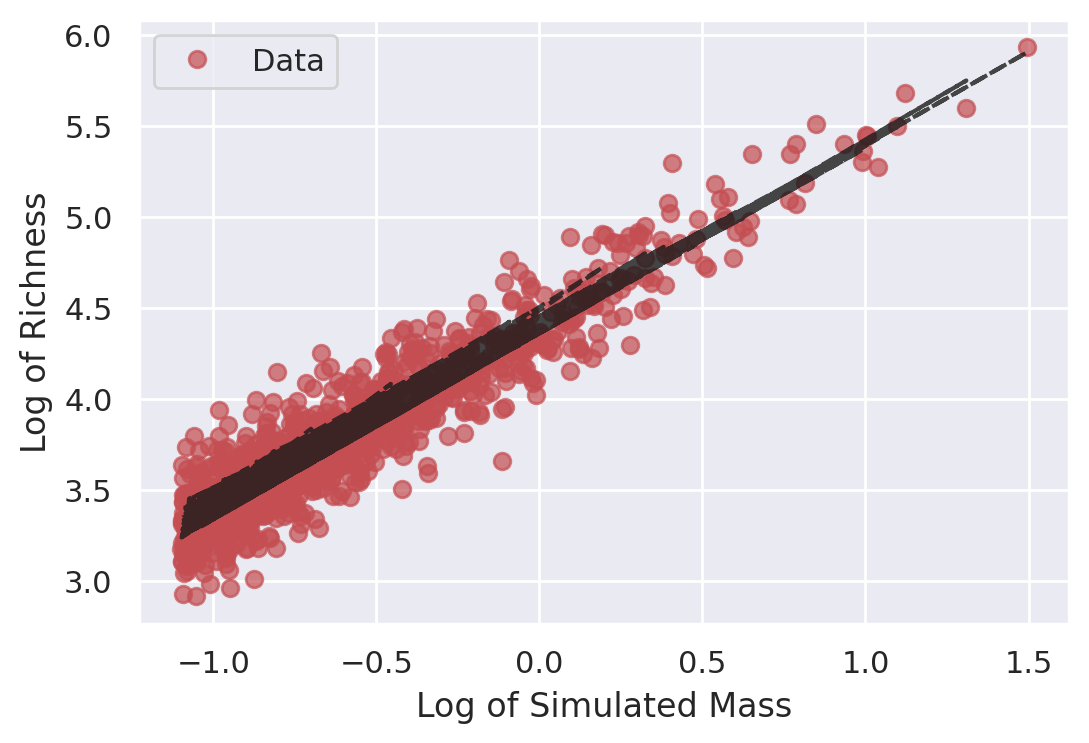

In [11]:
log_msims = np.log(msims/M0)

x1 = log_msims
y1 = ln_lambda

f=lambda x,a,b: a*x + b
fit=curve_fit(f, x1, y1)
xsmooth=np.linspace(np.min(x1), np.max(x1), 1000)
plt.plot(x1,y1,'ro',label='Data', alpha = 0.7)
#plt.plot(xsmooth,f(xsmooth,*fit[0]),'b-',linewidth=2,label='Logarithmic Fit')
plt.xlabel('Log of Simulated Mass')
plt.ylabel('Log of Richness')
plt.legend()

# Unlike the 1-D plot above (simple straight line), this is a vector that
# will create a slope which matches the log value from the previously
# calculated log of lambda based on the true parameter values
# found in (Grandis et al. 2021)

# Meant to compare with the simple 1-D plot above and display
# whether the simulated data is following the trend set by the real parameter values

plt.plot(x1, ln_lambda_true, 'k--', label='Truth', alpha = 0.8)

print('Combination of Slope and Y-Intercept:', fit[0])
print('Slope:', fit[0][0])
print('Y-Intercept:', fit[0][1])

Combination of Slope and Y-Intercept: [1.49304084 1.73310706]
Slope: 1.4930408444929324
Y-Intercept: 1.7331070639043191


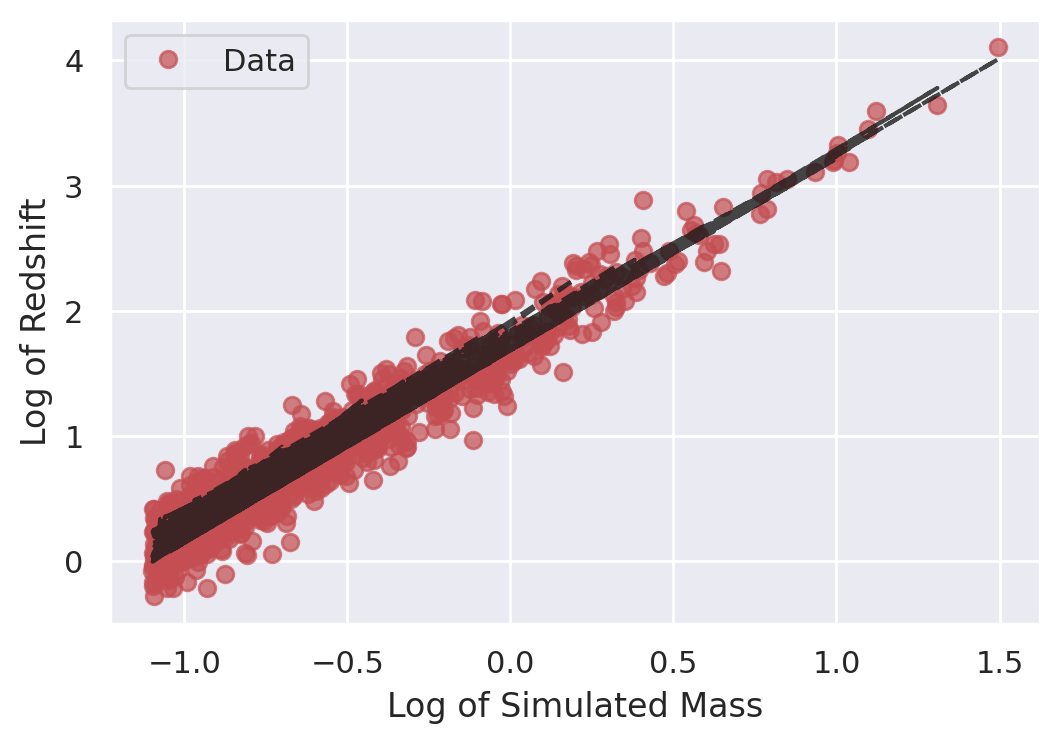

In [12]:
x2 = log_msims
y2 = ln_zeta

f=lambda x,a,b: a*x + b
fit=curve_fit(f, x2, y2)
xsmooth=np.linspace(np.min(x2), np.max(x2), 1000)
plt.plot(x2,y2,'ro',label='Data', alpha = 0.7)
#plt.plot(xsmooth,f(xsmooth,*fit[0]),'b-',linewidth=2,label='Logarithmic Fit')
plt.xlabel('Log of Simulated Mass')
plt.ylabel('Log of Redshift')
plt.legend()


# Unlike the 1-D plot above (simple straight line), this is a vector that
# will create a slope which matches the log value from the previously
# calculated log of zeta based on the true parameter values
# found in (Grandis et al. 2021)

# Meant to compare with the simple 1-D plot above and display
# whether the simulated data is following the trend set by the real parameter values

plt.plot(x1, ln_zeta_true, 'k--', label='Truth', alpha = 0.8)

print('Combination of Slope and Y-Intercept:', fit[0])
print('Slope:', fit[0][0])
print('Y-Intercept:', fit[0][1])

In [13]:
out = dict()
out['z'] = zsims
out['M'] = msims
out['lambda'] = np.exp(ln_lambda)
out['zeta'] = np.exp(ln_zeta)
out['lambda_true'] = np.exp(ln_lambda_true)
out['zeta_true'] = np.exp(ln_zeta_true)

df = pd.DataFrame(out, columns = ['z', 'M', 'lambda', 'zeta', 'lambda_true', 'zeta_true'])
#df.to_csv(r'C:\MuStar_Project\mustar-summar-project\simple_model\fake_data_Jun21.csv', index=False)
df.to_csv('fake_data_Jun21.csv', index=False)
print(df)
# pd.DataFrame.to_csv('fake_data_Jun21.csv')

            z             M      lambda      zeta  lambda_true  zeta_true
0    0.233892  3.579864e+14  103.427606  6.532938    95.137239   7.239986
1    0.139343  3.012447e+14   77.422977  5.674946    78.679506   5.433497
2    0.168206  2.608140e+14   77.135877  5.493110    68.206373   4.384910
3    0.527714  1.216552e+14   33.270592  1.584931    33.174886   1.491692
4    0.249406  1.739850e+14   64.940017  3.173674    45.683035   2.402686
..        ...           ...         ...       ...          ...        ...
995  0.232988  1.297022e+14   36.431744  2.011933    33.771730   1.525008
996  0.923643  1.350913e+14   32.500031  1.688661    39.472729   1.950298
997  0.140338  2.863682e+14   85.362855  5.425760    74.728919   5.028500
998  0.111959  1.881439e+14   61.147205  2.500764    48.491937   2.623013
999  0.429742  1.586862e+14   57.264221  2.880721    42.801168   2.184633

[1000 rows x 6 columns]


# Creating an MCMC Model

Using the Simple Model Likelihood in order to see how accurate the predicted MCMC values are from the known true values

In [14]:
SZ_Priors = {'A_sze':[5.24, 0.85], 'B_sze':[1.534, 0.100],'C_sze':[0.465, 0.407],
             'scatter_sze':[0.161, 0.080]}

sz_theta_values = ['A_sze', 'B_sze', 'C_sze', 'scatter_sze']

Lambda_Priors = {'A_lambda':[76.9, 8.2], 'B_lambda':[1.020, 0.080],'C_lambda':[0.23, 0.16],
             'scatter_lambda':[0.23, 0.16]}

lambda_theta_values = ['A_lambda', 'B_lambda', 'C_lambda', 'scatter_lambda']

In [15]:
display(df)

,z,M,lambda,zeta,lambda_true,zeta_true
0,0.233892,3.579864e+14,103.427606,6.532938,95.137239,7.239986
1,0.139343,3.012447e+14,77.422977,5.674946,78.679506,5.433497
2,0.168206,2.608140e+14,77.135877,5.493110,68.206373,4.384910
3,0.527714,1.216552e+14,33.270592,1.584931,33.174886,1.491692
4,0.249406,1.739850e+14,64.940017,3.173674,45.683035,2.402686
...,...,...,...,...,...,...
995,0.232988,1.297022e+14,36.431744,2.011933,33.771730,1.525008
996,0.923643,1.350913e+14,32.500031,1.688661,39.472729,1.950298
997,0.140338,2.863682e+14,85.362855,5.425760,74.728919,5.028500
998,0.111959,1.881439e+14,61.147205,2.500764,48.491937,2.623013


In [16]:
ix = np.where(np.array(df['lambda'])>5)[0] # take 100 points
Np = ix.size

yerr = 0.05*np.ones_like(zsims)

redshift = np.array(df['z'])[ix]
measured_sz_signal = np.array(df['zeta'])[ix]
measured_lambda = np.array(df['lambda'])[ix]
measured_lambda_error = np.array(yerr)[ix]
Mass = np.array(df['M'])

# for a given cluster, i.e. a vector (lbd_hat_i, chisi_i, z_i)
# ix = np.arange(len(lambda_chisq))[lambda_chisq>0][np.argmin(sz_signal[lambda_chisq>0])]
ix = np.arange(len(np.array(df['lambda'])))[np.array(df['lambda'])>0][np.argmax(np.array(df['lambda'])[np.array(df['lambda'])>0])]

measured_lambda_i = np.array(df['lambda'])[ix]
measured_lambda_error_i = np.array(yerr)[ix]
measured_sz_signal_i = np.array(df['zeta'])[ix]
redshift_i = np.array(df['z'])[ix]

In [17]:
x1 = np.array([ df['M'], df['z']])
# or x = (msims, zsims) since out['z'] = zsims & out['M'] = msims
#y = np.array([df['lambda'], df['zeta']])
#x = np.vstack([df['M'], df['z']])
#y = np.vstack([df['lambda'], df['zeta']])
#yerr = 0.05*np.ones_like(zsims)
x = np.vstack([Mass, redshift])
y = np.vstack([measured_lambda, measured_sz_signal])
print(x)
print(x1)

[[3.57986374e+14 3.01244654e+14 2.60814037e+14 ... 2.86368209e+14
  1.88143856e+14 1.58686181e+14]
 [2.33891746e-01 1.39342781e-01 1.68206460e-01 ... 1.40337606e-01
  1.11959040e-01 4.29741554e-01]]
[[3.57986374e+14 3.01244654e+14 2.60814037e+14 ... 2.86368209e+14
  1.88143856e+14 1.58686181e+14]
 [2.33891746e-01 1.39342781e-01 1.68206460e-01 ... 1.40337606e-01
  1.11959040e-01 4.29741554e-01]]


In [18]:
eps  =1e-9
lbd  = measured_lambda[0]
zeta = measured_sz_signal[0]

theta = [5.24, 1.534, 0.465, 0.161, 76.9, 1.02, 0.29, 0.16, 0.8]

(array([324., 240., 185., 103.,  75.,  37.,  16.,   7.,   7.,   2.]),
 array([14.00022932, 14.112826  , 14.22542269, 14.33801937, 14.45061605,
        14.56321273, 14.67580941, 14.7884061 , 14.90100278, 15.01359946,
        15.12619614]),
 <BarContainer object of 10 artists>)

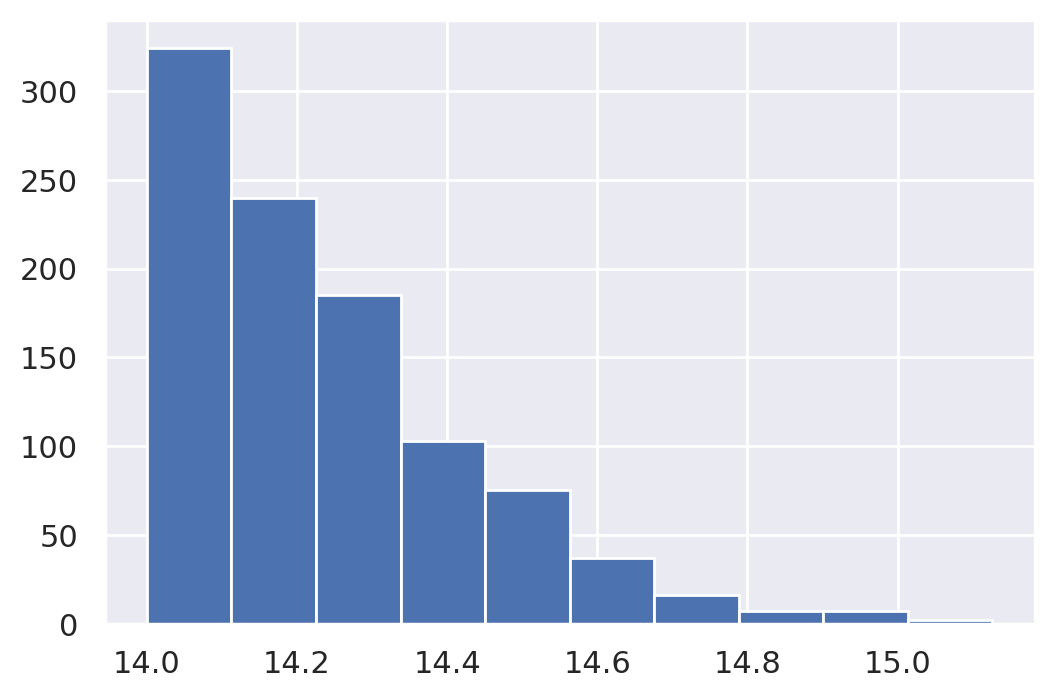

In [19]:
plt.hist(np.log10(df['M'][np.array(df['lambda'])>20]))

In [20]:
# set up integration vectors
# mvec = np.logspace(13.8, 15.5, 75)
# lbdvec = np.linspace(3,1.2*np.max(lambda_chisq),150)
lbdvec = np.linspace(3, 1.2*np.max(np.array(df['lambda'])), 29)
# zetavec = np.linspace(1,1.1*np.max(sz_signal),75)
zetavec = np.linspace(1, 1.1*np.max(np.array(df['zeta'])), 24)

print('Vector size')
## print(mvec.size)
print(lbdvec.size)
print(zetavec.size)

Vector size
29
24


In [21]:
zvec = np.linspace(np.min(np.array(df['z'])), np.max(np.array(df['z'])), 100)
## zzv, mm = np.meshgrid(zvec, mvec)
zzv= np.meshgrid(zvec)
from scipy import interpolate
## halo_mass_function2 = interpolate.interp1d(zvec, halo_mass_function(mm, zzv), kind='cubic')

In [22]:
def slice_array(y,alpha=1e-2):
    cy = np.cumsum(y/np.sum(y),axis=0)
    ilo,iup = np.interp([alpha,1-alpha],cy,np.arange(len(y))).astype(int)+(0,2)
    return ilo, iup

In [23]:
def prob_chisi(zeta, measured_sz_signal, eps=1e-12):
    res = np.exp(-(measured_sz_signal-np.sqrt(zeta**2+2))**2/2.)/np.sqrt(2*np.pi)
    return res#np.where(res<eps,0.,res)

def gaussian(x,mu,std):
    return np.exp(-(x-mu)**2/std**2/2.)/np.sqrt(2*np.pi*std**2)

def prob_lbd_hat(lbd, measured_lambda ,yerr #lbd_error
                 , eps=1e-12):
    res = gaussian(lbd, measured_lambda, yerr)
    return res#np.where(res<eps,0.,res)

In [27]:
prob_lbd_hat_vec = np.array([prob_lbd_hat(lbdvec, measured_lambda_i, measured_lambda_error_i) 
                             for measured_lambda_i, measured_lambda_error_i in zip(measured_lambda, measured_lambda_error)])
prob_chisi_vec = np.array([prob_chisi(zetavec, measured_sz_signal_i) for measured_sz_signal_i in measured_sz_signal])

print(prob_lbd_hat_vec.shape)

alpha = 0.1
lbd_indices_vec = np.array([slice_array(pi, alpha=alpha) for pi in prob_lbd_hat_vec])
zeta_indices_vec = np.array([slice_array(pi, alpha=alpha) for pi in prob_chisi_vec])
lbd_indices_vec.shape

(1000, 29)


<ipython-input-22-90d38f6343cc>:2: RuntimeWarning: invalid value encountered in true_divide
  cy = np.cumsum(y/np.sum(y),axis=0)


(1000, 2)

In [28]:
from scipy.integrate import simps

# given: mvec, lbdvec and zetavec

zz, ll = np.meshgrid(zetavec, lbdvec, indexing='ij')

def log_likelihood_vec2(theta, indices, eps=1e-9):
    # defining variables
    probs = []
    for ix in indices:
        probs.append(_log_likelihood2(theta, ix))
    p = np.array(probs)/np.sum(probs)
    log_p = np.log(p)
    log_p = np.where(np.isnan(log_p), -np.inf, log_p)
    return np.sum(log_p)

In [65]:
def _log_likelihood2(theta, ix):
    # unfolding theta
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
    A_sze, B_sze, C_sze, scatter_sze = theta[:4]
    rho = theta[-1]
    
    redshift_i = redshift[ix]
    p_chisi = prob_chisi_vec[ix]
    p_lbd_hat = prob_lbd_hat_vec[ix]
    llo, lup = list(lbd_indices_vec[ix])
    clo, cup = list(zeta_indices_vec[ix])
    #halo_mass_func = hmf_vector[ix]

    # calling predictions;
    ln_lbd_pred = ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda], #mvec
                                 msims, zsims)
    ln_zeta_pred= ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze],# mvec
                                  msims, zsims)
    
    #hmf = np.tile(halo_mass_func, (int(lup-llo), int(cup-clo), 1)).T
    ln_lbd_pred = np.tile(ln_lbd_pred, (int(lup-llo), int(cup-clo), 1)).T
    ln_zeta_pred = np.tile(ln_zeta_pred, (int(lup-llo), int(cup-clo), 1)).T
    
    # compute dn_dlbd_dzeta_integrand
    p_total_m = compute_dn_dlbd_dzeta_vec2(measured_lambda_i, measured_lambda_error_i, measured_sz_signal_i,
                                           scatter_lambda, scatter_sze, rho,
                                           ll[:,clo:cup,llo:lup],zz[:,clo:cup,llo:lup],
                                           ln_lbd_pred, ln_zeta_pred, #hmf
                                          )
    # integrate over M
    p_lbd_zeta = np.trapz(p_total_m, x=mvec, axis=0)

    # integrate over zeta
    p_chisi = np.tile(p_chisi[clo:cup], (int(lup-llo), 1)).T
    p_lbd = np.trapz(p_lbd_zeta*p_chisi, x=zetavec[clo:cup], axis=0)

    # integrate over lambda
    p = np.trapz(p_lbd*p_lbd_hat[llo:lup], x=lbdvec[llo:lup], axis=0)
    return p

In [66]:
def compute_dn_dlbd_dzeta_vec2(measured_lambda_i, measured_lambda_error_i, measured_sz_signal_i, scatter_lambda, scatter_sze, rho,
                               lvec, zvec, ln_lbd_pred, ln_zeta_pred, eps = 1e-9):
    # converting std to normal distribution
    s_zeta = logNormal_variance(ln_zeta_pred, scatter_sze)
    s_lambda = logNormal_variance(ln_lbd_pred, scatter_lambda)
    # Should these two statements above be commented out or not?
    
    s_zeta = np.where(scatter_sze<=eps, -np.inf, 1/scatter_sze)
    s_lambda = np.where(scatter_lambda<=eps, -np.inf, 1/scatter_lambda)
    
    cov = ((scatter_lambda)**(2))*((scatter_sze)**(2))*(1-(rho**2))
    additional_cov = (-0.5)*np.log((np.pi*cov**2))
    
    # avoid error messages
    rho_inv = (1-rho**2)
    rho_inv = np.where(rho_inv<=eps, -np.inf, 1/rho_inv)
    
    
    # defining standardized variables
    lbd_std = (np.log(lvec) - (ln_lbd_pred))*s_lambda
    zeta_std = (np.log(zvec)- (ln_zeta_pred))*s_zeta
    np.seterr(invalid='ignore')

    # lbd_likelihood
    lp_lbd  = (-rho_inv*lbd_std**2)/2

    # zeta likelihood
    lp_zeta = (-rho_inv*zeta_std**2)/2

    # corr likelihod
    lp_corr = rho*rho_inv*lbd_std*zeta_std

    lp_total_m = lp_lbd + lp_zeta + lp_corr + additional_cov
    
    p_total_m = (np.exp(lp_total_m))/(lvec*zvec)
    
    return p_total_m

In [67]:
rho = theta[-1]
scatter_sze = theta[3]
scatter_lambda = theta[7]


def set_gaussian_prior(param, mu, sigma):
    return -0.5*((param - mu)/(sigma))**2

# Setting SZE priors
def set_prior_sze(theta_values):
    lp = 0.
    rhomin = 0.
    rhomax = 1.
    
    for i, prior_name in enumerate(['A_sze', 'B_sze', 'C_sze', 'scatter_sze']):
        mean, error = SZ_Priors[prior_name]
        param = theta_values[i]
        result = set_gaussian_prior(param, mean, error)
        lp += np.where(np.abs(result)>9., -np.inf, result)
        # outside a range of six sigmas (six standard deviations)
    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range 
    lp = 0. if (theta_values[-1] > 0) else -np.inf
    return lp

# Setting Lambda priors
def set_prior_lambda(theta_values):
    lp = 0.
    rhomin = 0.
    rhomax = 1.
    
    for i, prior_name in enumerate(['A_lambda', 'B_lambda', 'C_lambda', 'scatter_lambda']):
        mean, error = Lambda_Priors[prior_name]
        param = theta_values[i]
        result = set_gaussian_prior(param, mean, error)
        lp += np.where(np.abs(result)>9., -np.inf, result)
        # outside a range of six sigmas (six standard deviations)
       
    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range 
    lp = 0. if (theta_values[-1] > 0) else -np.inf
    return lp

def logprior(theta):
    lp = 0
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
    A_sze, B_sze, C_sze, scatter_sze = theta[:4]
    rho = theta[-1]
    
    lp_lambda = set_prior_lambda([A_lambda, B_lambda, C_lambda, scatter_lambda])
    lp_sze = set_prior_sze([A_sze, B_sze, C_sze, scatter_sze])
    
    lp = 0. if ((rho > 0) and (rho < 1)) else -np.inf
    return lp + lp_lambda + lp_sze

In [68]:
def logposterior(theta, indices):
    lp = logprior(theta)
    
    # if the prior is not finite return a probability of zero (log probability of -inf)
    if not np.isfinite(lp):
        return -np.inf
    
    # return the likeihood times the prior (log likelihood plus the log prior)
    return lp + log_likelihood_vec2(theta, indices, eps=1e-9)

In [69]:
set_prior_sze([5.24, 1.534, 0.465, 0.161])

0.0

In [70]:
Nburnin = 600 # number of burn-in samples
Nsamples = 1800 # number of final posterior samples
walkers = 100
ndims = len(theta)
guess = (np.array(theta)[:, np.newaxis]*(1.+0.01*np.random.normal(size=(ndims,walkers)))).T

# set additional args for the posterior (the data, the noise std. dev., and the abscissa)
sel = np.arange(len(redshift))#[:100]
sel = np.random.randint(len(redshift), size=100, dtype=int)
argslist = [sel]

In [71]:
logposterior(theta, sel)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood_vec2(*args)
initial = theta + 0.1 * np.random.randn(9)
soln = minimize(nll, initial, args=sel)
albd, blbd, clbd, slbd, rho = soln.x[4:]

print("Maximum likelihood estimates:")
print("Albd = {0:.3f}".format(albd))
print("Blbd = {0:.3f}".format(blbd))
print("Clbd = {0:.3f}".format(clbd))
print("Scatter_lbd = {0:.3f}".format(slbd))
print("rho: {0:.3f}".format(rho))

In [ ]:
theta

In [ ]:
soln.x[-1]

In [ ]:
import time
from multiprocessing import Pool
with Pool(processes = 16) as pool:
    sampler = emcee.EnsembleSampler(walkers, ndims, logposterior,args=argslist, pool=pool)
    start = time.time()
    sampler.run_mcmc(guess, Nsamples+Nburnin, progress=True)
    end = time.time()
    multi_time = end - start
    serial_time = (1.5)*(3600)
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    print("{0:.1f} times faster than serial".format(serial_time / multi_time))